In [ ]:
!pip install pymc3

In [ ]:
!pip install pandas==1.5.2

## Libraries:

In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import arviz as az
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import halfnorm
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()
az.style.use('arviz-darkgrid')
np.random.seed(44)

## Preprocessing
For the unpooled and hierarchical models

In [133]:
# Data
training = pd.read_pickle("train.pkl")
testing = pd.read_pickle("test.pkl")

# Save the player for novel predictions
novel_player_features = training.tail(1).x_train_1.values[0]

# remove the last row with the problematic player
training = training.drop(training.index[[-1]])
testing = testing.drop(testing.index[[-1]])

# Features and labels:
x_train = [np.concatenate(training.iloc[i, 2:42].values).reshape(40, 40) for i in range(5)]
y_train = [training.iloc[i, 42:82].values.astype(np.float64) for i in range(5)]
x_test = [testing.iloc[i, 1].reshape(40, 1) for i in range(5)]
y_test = [testing.iloc[i, 2].astype(np.float64) for i in range(5)]

## Unpooled model

In [ ]:
unpooled_models = []
unpooled_traces = []
for i in range(5):
    # sampling variables
    mu_y = y_train[i].mean()
    s_y = y_train[i].std()
    s_x = np.mean(np.std(x_train[i]))

    # model
    with pm.Model() as unpooled_model:
        # priors:
        alpha = pm.Normal('alpha', mu=mu_y, sigma=s_y)
        beta = pm.Normal('beta', mu=0, sigma=s_x, shape=40)
        sigma = pm.HalfNormal('sigma', sigma=s_y)

        # likelihood:
        mu = alpha + pm.math.dot(x_train[i], beta)

        # observed data:
        y_pred = pm.StudentT ('y_pred', nu=4, mu=mu, sd=sigma, 
                              observed= y_train[i])
        trace = pm.sample(1000, tune=1000, cores=2, chains=2)

    unpooled_models.append(unpooled_model)
    unpooled_traces.append(trace)

### Convergence check

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6359c6f160>,
      dtype=object)

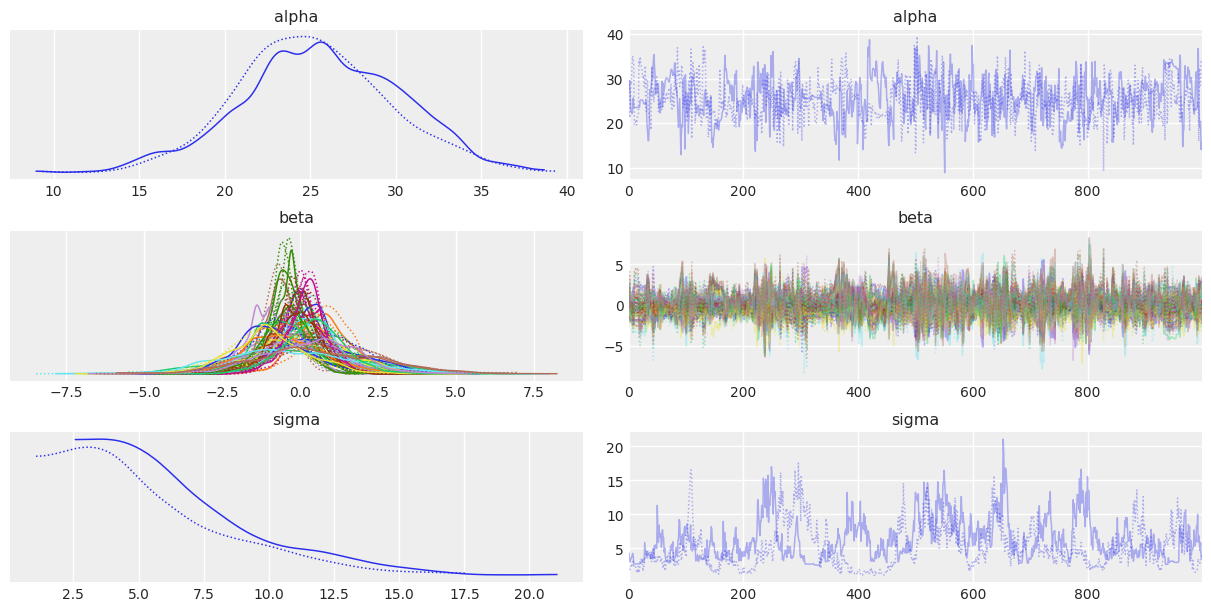

In [89]:
az.plot_trace(unpooled_traces[0])

## Posterior prediction of the mean for LeBron James with the unpooled model

In [111]:
x_lebron = np.array(x_train)[0, :, :]
x_lebron.shape

(40, 40)

In [109]:
trace_lb = unpooled_traces[0]
model_lb = unpooled_models[0]

In [113]:
alpha_samples = trace_lb['alpha'][0]
beta_samples = trace_lb['beta'][0]
mu_player = alpha_samples + np.dot(x_lebron, beta_samples.T)

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


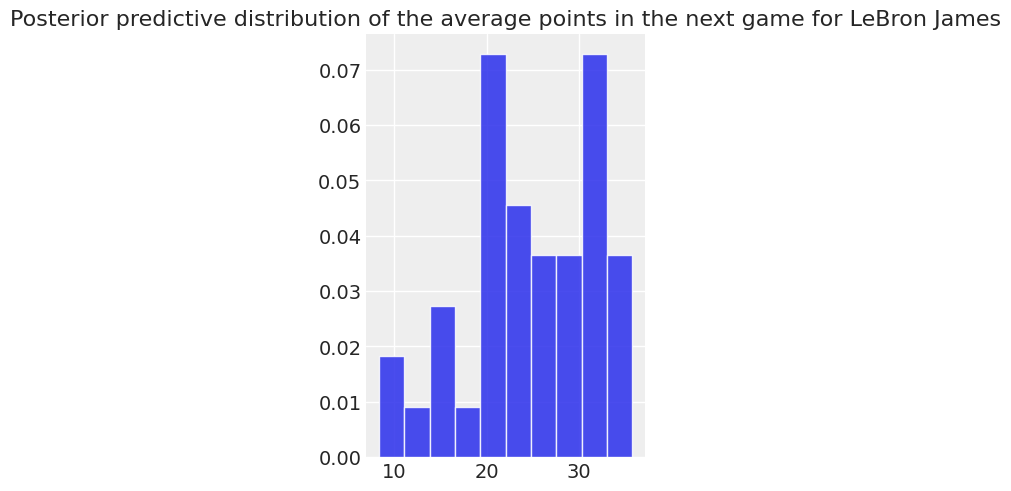

LeBron James predicted mean: 24.676
LeBron James predicted mean standard deviation: 6.813


In [117]:
# plot the posterior mean distribution
plt.hist(mu_player, bins=10, density=True, alpha=0.85)
plt.title('Posterior predictive distribution of the average points in the next game for LeBron James')
plt.show()

# print the mean and standard deviation of the posterior predictive distribution
print(f'LeBron James predicted mean: {mu_player.mean():.3f}')
print(f'LeBron James predicted mean standard deviation: {mu_player.std():.3f}')

### Posterior prediction of LeBron's points with the unpooled model

In [118]:
post_up = az.convert_to_dataset(trace_lb)
mu_lb_up = post_up.alpha[0]
sigma_up = post_up.sigma.values[0]

y_lb_unpooled = np.zeros(len(mu_lb_up))

for i, current_mu in enumerate(mu_lb_up):
    y_lb_unpooled[i] = np.random.normal(loc = mu_lb_up[i], scale = sigma_up[i])

df = pd.DataFrame(y_lb_unpooled)
df.describe(percentiles=[0.025, 0.975])

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


0
count  1000.000000
mean     25.932908
std       8.523534
min     -14.288413
2.5%     10.162417
50%      25.717873
97.5%    43.319006
max      60.584084

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


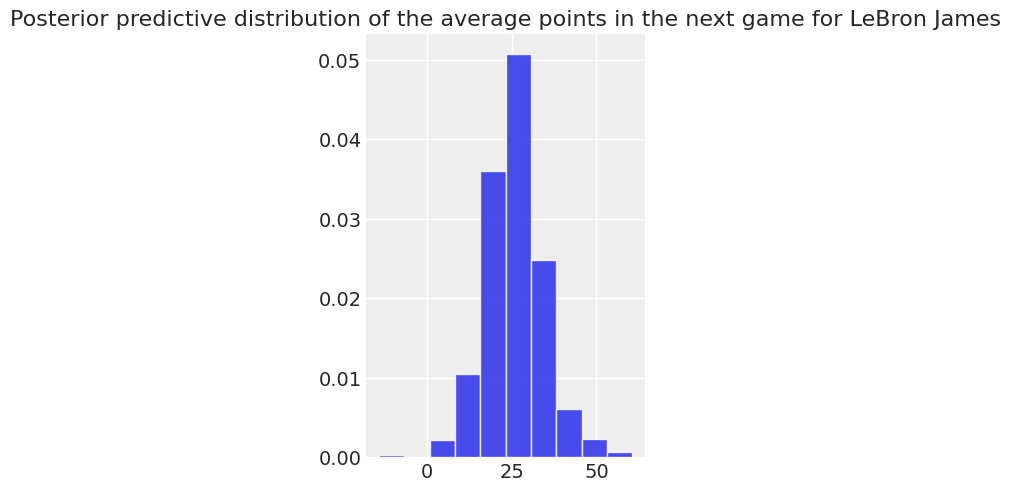

LeBron James predicted points: 25.933
LeBron James predicted points standard deviation: 8.519


In [170]:
# plot the posterior predictive distribution
plt.hist(y_lb_unpooled, bins=10, density=True, alpha=0.85)
plt.title('Posterior predictive distribution of the average points in the next game for LeBron James')
plt.show()

# print the mean and standard deviation of the posterior predictive distribution
print(f'LeBron James predicted points: {y_lb_unpooled.mean():.3f}')
print(f'LeBron James predicted points standard deviation: {y_lb_unpooled.std():.3f}')

## Hierarchical model

In [ ]:
hier_models = []
hier_traces = []
for i in range(5):
    with pm.Model() as hierarchical_model_mlr:
        # hyper-priors
        mu_alpha = pm.Normal('mu_alpha', mu=mu_y, sigma=s_y)
        sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=10)
        mu_beta = pm.Normal('mu_beta', mu=0, sigma=1, shape=40)
        sigma_beta = pm.HalfNormal('sigma_beta', sigma=1)
        sigma = pm.HalfNormal('sigma', sigma=s_y)

        # priors
        alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha)
        beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta, shape=40)

        # likelihood
        mu = alpha + pm.math.dot(x_train[i], beta)
        y_pred = pm.StudentT('y_pred', nu=4, mu=mu, sd=sigma, observed=y_train[i])

        trace = pm.sample(1000, tune=1000, cores=2, chains=2)
        hier_models.append(hierarchical_model_mlr)
        hier_traces.append(trace)


## Posterior mean for LeBron James with the hierarchical model

In [121]:
trace_lb_hier = hier_traces[0]
model_lb_hier = hier_models[0]

In [124]:
alpha_samples = trace_lb_hier['alpha'][0]
beta_samples = trace_lb_hier['beta'][0]
mu_player_hier = alpha_samples + np.dot(x_lebron, beta_samples.T)

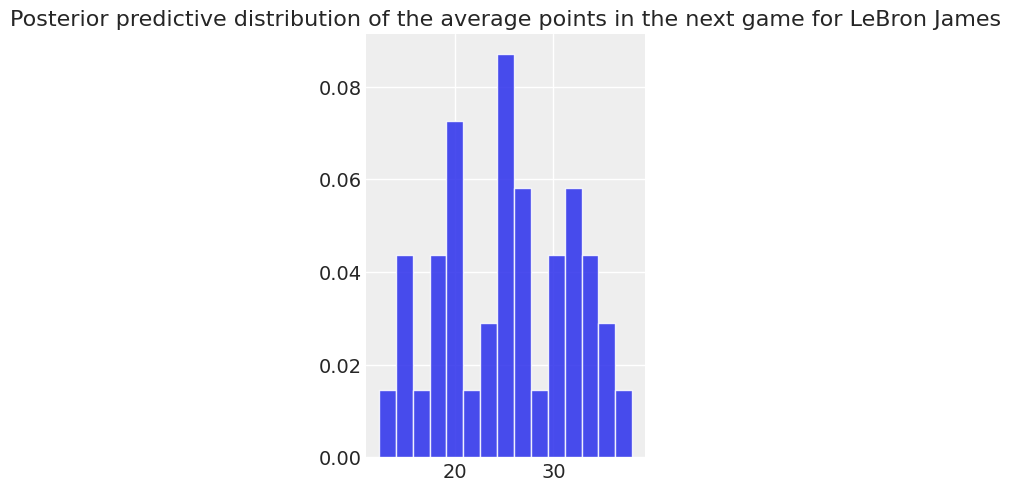

LeBron James predicted mean: 25.270
LeBron James predicted mean standard deviation: 6.618


In [126]:
# plot the posterior mean distribution
plt.hist(mu_player_hier, bins=15, density=True, alpha=0.85)
plt.title('Posterior predictive distribution of the average points in the next game for LeBron James')
plt.show()

# print the mean and standard deviation of the posterior predictive distribution
print(f'LeBron James predicted mean: {mu_player_hier.mean():.3f}')
print(f'LeBron James predicted mean standard deviation: {mu_player_hier.std():.3f}')

## Posterior prediction for LeBron James with the hierarchical model

In [13]:
post_hier = az.convert_to_dataset(trace_lb_hier)
mu_lb_hier = post_hier.alpha[0]
sigma_hier = post_hier.sigma.values[0]

y_lb_hier = np.zeros(len(mu_lb_hier))

for i, current_mu in enumerate(mu_lb_hier):
    y_lb_hier[i] = np.random.normal(loc = mu_lb_hier[i], scale = sigma_hier[i])

#the predictions of the hierarchical model are slightly lower and pulled towards the mean of the pooled model.
#yet the difference is small since there are many songs from Beyonce. 
df = pd.DataFrame(y_lb_hier)
df.describe(percentiles=[0.025, 0.975])

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


0
count  1000.000000
mean     25.750458
std       3.575120
min       5.817022
2.5%     17.902879
50%      25.741058
97.5%    33.190560
max      42.167776

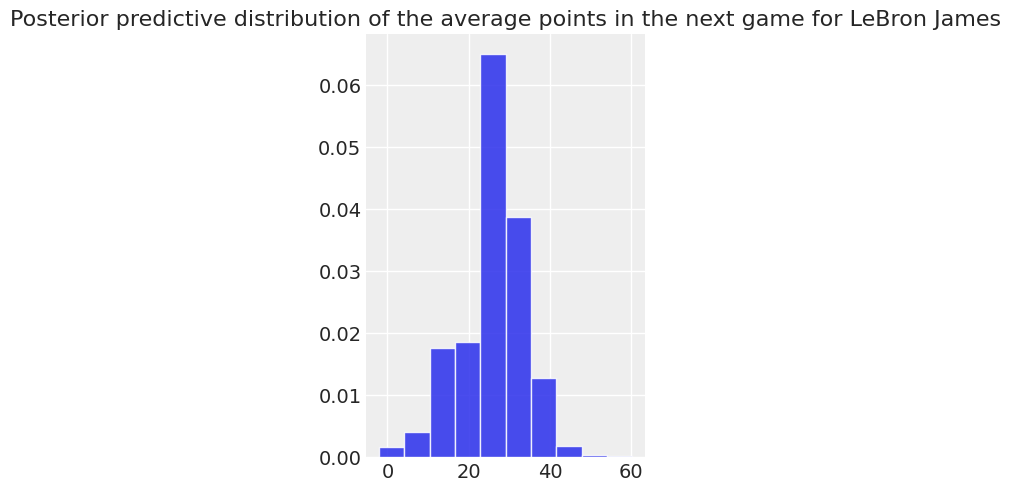

LeBron James predicted points: 25.928
LeBron James predicted points standard deviation: 7.728


In [171]:
# plot the posterior predictive distribution
plt.hist(y_lb_hier, bins=10, density=True, alpha=0.85)
plt.title('Posterior predictive distribution of the average points in the next game for LeBron James')
plt.show()

# print the mean and standard deviation of the posterior predictive distribution
print(f'LeBron James predicted points: {y_lb_hier.mean():.3f}')
print(f'LeBron James predicted points standard deviation: {y_lb_hier.std():.3f}')

### Novel prediction with the hierarchical model

In [196]:
x_new = novel_player_features
x_new = np.array(x_new, dtype=float)

In [206]:
with pm.Model() as h_w_pred:
    # hyper-priors
    # we modified the hyper-priors of beta to fit expected parameters.
    # The problems is we did not build into the priors that a positive
    # relationship exists between beta and y_observed, the values from 
    # Wayne Ellington are high, just highly negative, which makes the model
    # explode.
    mu_alpha = pm.Normal('mu_alpha', mu=mu_y, sigma=s_y)
    sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=4)
    mu_beta = pm.Normal('mu_beta', mu=0, sigma=0.1, shape=40)
    sigma_beta = pm.HalfNormal('sigma_beta', sigma=0.05)
    sigma = pm.HalfNormal('sigma', sigma=s_x)

    # priors
    alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha)
    beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta, shape=40)

    # likelihood
    mu = alpha + pm.math.dot(x_train[0], beta)
    y_pred = pm.StudentT('y_pred', nu=4, mu=mu, sd=sigma, observed=y_train[0])

    # Novel player
    x_novel = pm.Data("x_novel", x_new)
    mu_novel = alpha + pm.math.dot(x_novel, beta)
    y_novel = pm.Normal("y_novel", mu=mu_novel, sigma=sigma)

    trace_h = pm.sample(1000, tune=1000, cores=2, chains=2)

/usr/local/lib/python3.8/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


ERROR:pymc3:There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [208]:
with h_w_pred:
    display(az.summary(trace_h, var_names=['y_novel']))

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
y_novel  31.18  14.211   6.873   58.281       0.59    0.418     575.0   

         ess_tail  r_hat  
y_novel    1145.0   1.01

## Convergence check

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


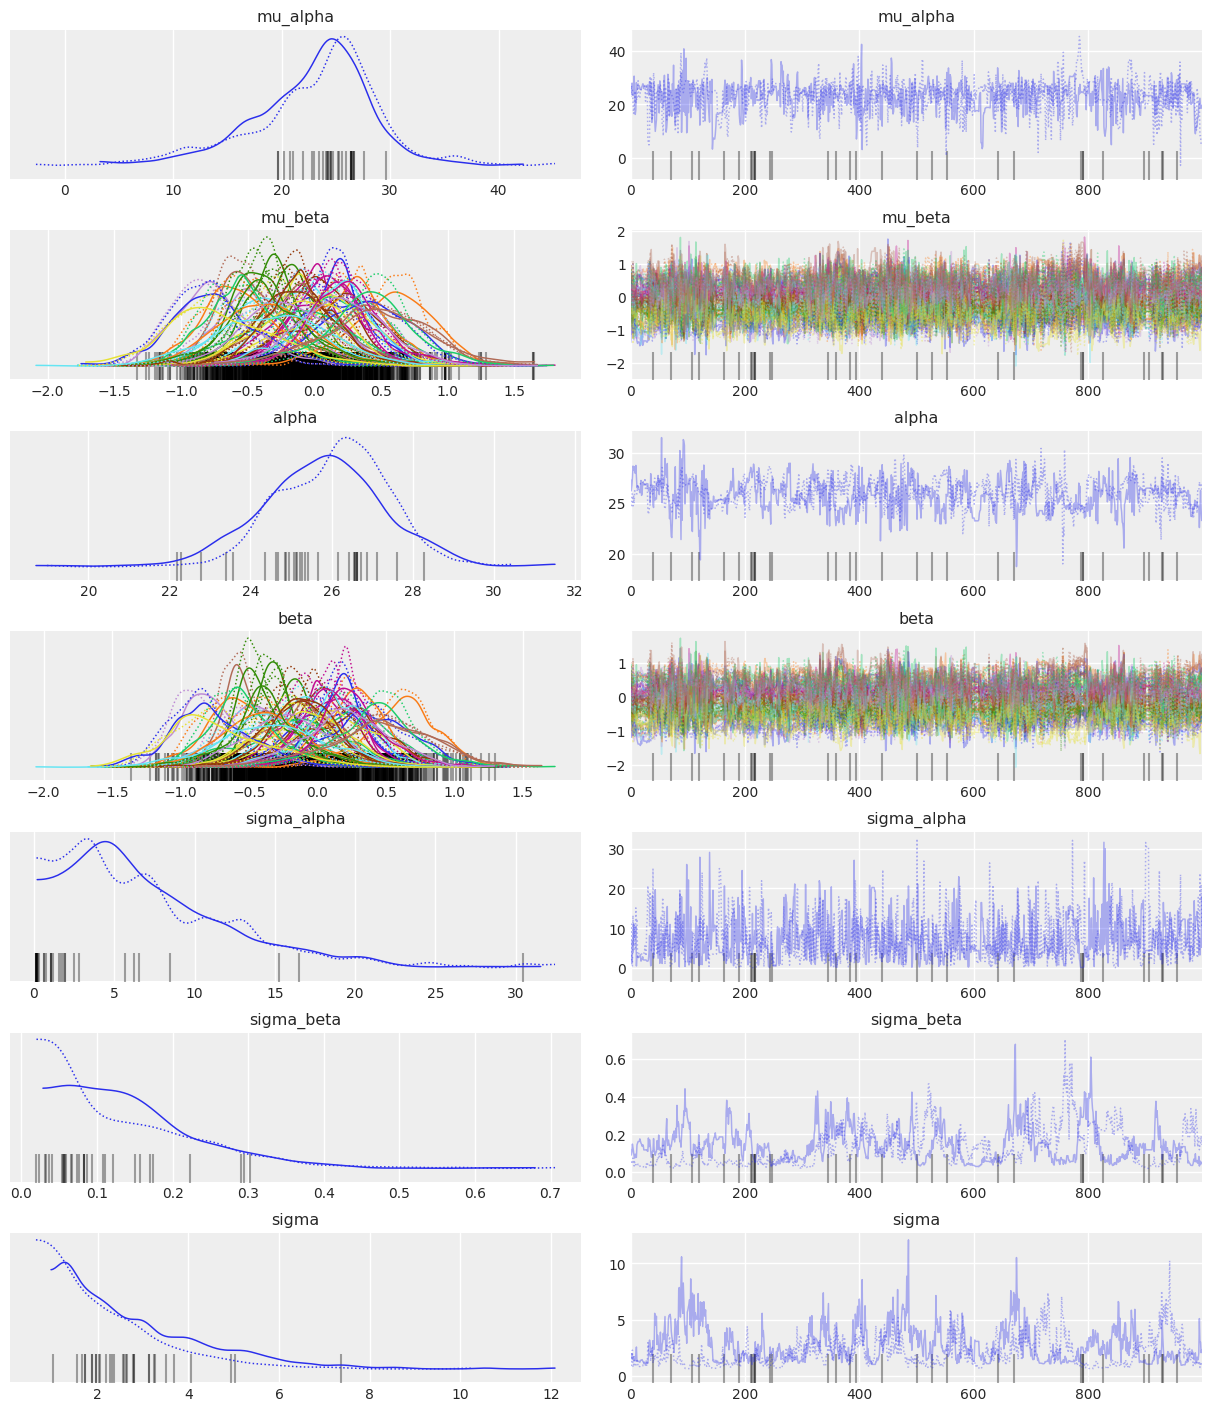

In [128]:
az.plot_trace(hier_traces[0]);

### Prior sensitivty for the hierarchical model

In [ ]:
hier_models_sens = []
hier_traces_sens = []
for i in range(5):
    with pm.Model() as hierarchical_model:
        # hyper-priors
        mu_alpha = pm.Uniform('mu_alpha', 0, 40)
        sigma_alpha = pm.HalfCauchy('sigma_alpha', beta=10)
        mu_beta = pm.Uniform('mu_beta', -5, 5, shape=40)
        sigma_beta = pm.HalfCauchy('sigma_beta', beta=1, shape=40)
        sigma = pm.HalfCauchy('sigma', beta=1)

        # priors
        alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha)
        beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta, shape=40)

        # likelihood
        mu = alpha + pm.math.dot(x_train[i], beta)
        y_pred = pm.StudentT('y_pred', nu=4, mu=mu, sd=sigma, observed=y_train[i])

        trace = pm.sample(1000, tune=1000, cores=2, chains=2)
        hier_models_sens.append(hierarchical_model_mlr)
        hier_traces_sens.append(trace)

In [61]:
trace_lb_hier = hier_traces_sens[0]
post_hier = az.convert_to_dataset(trace_lb_hier)
mu_lb_hier = post_hier.alpha[0]
sigma_hier = post_hier.sigma.values[0]

y_lb_hier = np.zeros(len(mu_lb_hier))

for i, current_mu in enumerate(mu_lb_hier):
    y_lb_hier[i] = np.random.normal(loc = mu_lb_hier[i], scale = sigma_hier[i])

#the predictions of the hierarchical model are slightly lower and pulled towards the mean of the pooled model.
#yet the difference is small since there are many songs from Beyonce. 
df = pd.DataFrame(y_lb_hier)
df.describe(percentiles=[0.025, 0.975])

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


0
count  1000.000000
mean     25.927782
std       7.731390
min      -2.079034
2.5%      9.821152
50%      27.172265
97.5%    39.459595
max      60.256666

/usr/local/lib/python3.8/dist-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


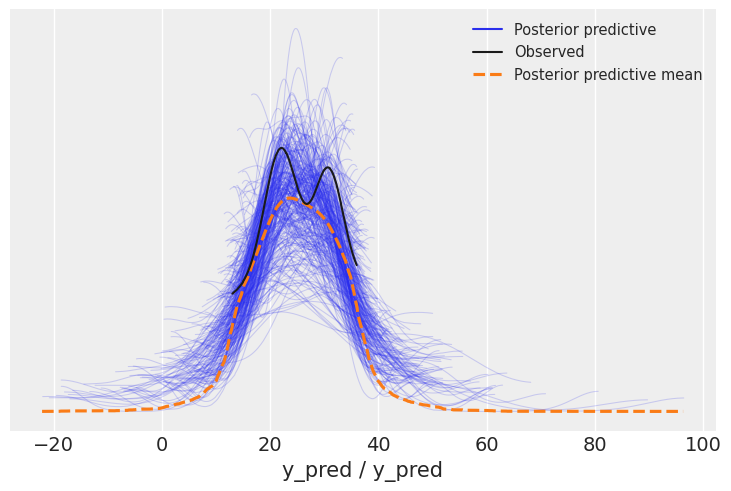

In [70]:
ppc = pm.sample_posterior_predictive(hier_traces[0], samples=300, model=hier_models[0])
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=hier_models[0]));

/usr/local/lib/python3.8/dist-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


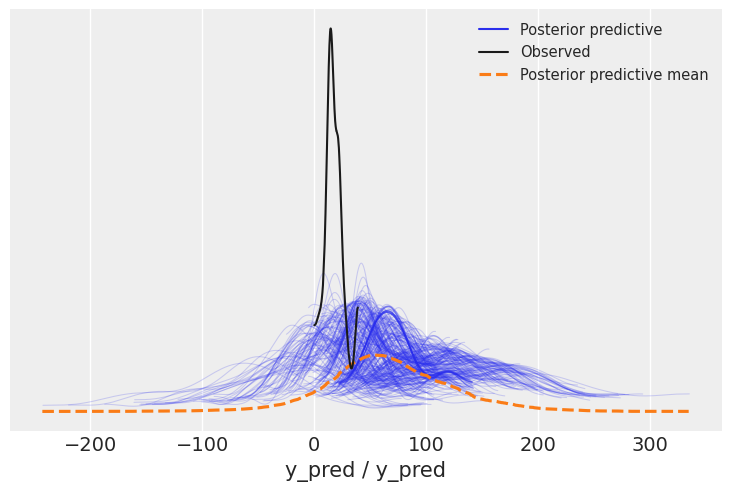

In [75]:
ppc = pm.sample_posterior_predictive(hier_traces_sens[0], samples=300, model=hier_models_sens[0])
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=hier_models_sens[0]));

### WAIC comparisons

In [209]:
for i in range(5):
  print(az.waic(hier_traces[i]))

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release

Computed from 2000 posterior samples and 40 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -124.35     0.85
p_waic       45.47        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Computed from 2000 posterior samples and 40 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -178.17     2.03
p_waic       39.30        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Computed from 2000 posterior samples and 40 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -143.64     1.30
p_waic       42.10        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Computed from 2000 posterior samples and 40 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -137.05     1.03
p_waic       47.78        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 40 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -175.38     2.77
p_waic       39.98        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [210]:
for i in range(5):
  print(az.waic(unpooled_traces[i]))

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release

Computed from 2000 posterior samples and 40 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -164.57     0.73
p_waic       50.38        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Computed from 2000 posterior samples and 40 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -201.41     4.32
p_waic       47.64        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Computed from 2000 posterior samples and 40 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -147.86     2.13
p_waic       40.79        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Computed from 2000 posterior samples and 40 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -179.26     1.06
p_waic       47.30        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 40 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -178.56     1.12
p_waic       43.05        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Summing the values, the hierarchical model is superior.